In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import json
import random

In [2]:
working_dir = os.getcwd()
print(f"You are now working in {working_dir}")
print("If you need to change to the parent directory, run the cell below")

You are now working in c:\Users\fredd\Desktop\Studier\Project5\flowers\flowers_CNN\jupyter_notebooks
If you need to change to the parent directory, run the cell below


In [3]:
os.chdir(os.path.dirname(working_dir))
new_working_dir = os.getcwd()
print(f"You have now changed your working directory to {new_working_dir}")

You have now changed your working directory to c:\Users\fredd\Desktop\Studier\Project5\flowers\flowers_CNN


In [4]:
version = 'v5'
file_path = f'outputs/{version}'
current_working_dir = os.getcwd()

if 'outputs' in os.listdir(current_working_dir) and version in os.listdir(current_working_dir + '/outputs'):
    print("This version already exists, create a new version if you are working on a new version")
    pass
else:
    os.makedirs(name=file_path)

This version already exists, create a new version if you are working on a new version


In [5]:
image_dirs = 'inputs/dataset/raw/flower_photos'
train_path = image_dirs + '/train'
val_path = image_dirs + '/validation'
test_path = image_dirs + '/test'

In [6]:
labels = os.listdir(train_path)
print(f"Flower labels: {labels}")

Flower labels: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [11]:


class ImageClassificationPipeline:
    def __init__(self, train_path, val_path, test_path, input_shape=(224, 224, 3), batch_size=20, num_classes=5):
        self.train_path = train_path
        self.val_path = val_path
        self.test_path = test_path
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.num_classes = num_classes

        # Initialize ImageDataGenerators
        self.train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=30,
            width_shift_range=0.10,
            height_shift_range=0.10,
            shear_range=0.1,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=False,
            fill_mode='nearest',
            brightness_range=[0.8, 1.2],
            channel_shift_range=0.1
        )
        self.val_test_datagen = ImageDataGenerator(rescale=1./255)

        # Build data generators
        self.train_set = self.train_datagen.flow_from_directory(
            self.train_path, target_size=self.input_shape[:2], batch_size=self.batch_size,
            class_mode='categorical', shuffle=True
        )
        self.validation_set = self.val_test_datagen.flow_from_directory(
            self.val_path, target_size=self.input_shape[:2], batch_size=self.batch_size,
            class_mode='categorical', shuffle=False
        )
        self.test_set = self.val_test_datagen.flow_from_directory(
            self.test_path, target_size=self.input_shape[:2], batch_size=self.batch_size,
            class_mode='categorical', shuffle=False
        )
        
        # Retrieve label map
        self.label_map = list(self.train_set.class_indices.keys())
        
        # Build model
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Conv2D(32, (5, 5), activation='relu', input_shape=self.input_shape),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),
            
            Conv2D(64, (5, 5), activation='relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),
            
            Conv2D(64, (5, 5), activation='relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),            
            
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(self.num_classes, activation='softmax')
        ])
        
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def train(self, epochs=25, early_stopping_patience=3):
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
        
        self.history = self.model.fit(
            self.train_set,
            validation_data=self.validation_set,
            epochs=epochs,
            callbacks=[early_stop],
            verbose=1
        )

    def evaluate(self, savepath=None,  cm_image_path=None): 
        y_pred_probs = self.model.predict(self.test_set)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = self.test_set.classes

        # Calculate F1 score
        f1 = f1_score(y_true, y_pred, average='weighted')
        print(f"F1 Score (weighted): {f1:.4f}")

        # Classification report
        report = classification_report(y_true, y_pred, target_names=self.label_map, output_dict=True)
        print("\nClassification Report:")
        print(report)

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.label_map)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()

        if cm_image_path:
            disp.plot(cmap=plt.cm.Blues)
            plt.savefig(cm_image_path, bbox_inches='tight', dpi=150)
            print(f"Confusion matrix image saved as {cm_image_path}")
        
        # If savepath is given, save JSON-file
        if savepath:
            evaluation_data = {
                "f1_score_weighted": f1,
                "classification_report": report,
                "confusion_matrix": cm.tolist()  # Converts numpy array to list for JSON-file
            }

            # Saves data as JSON-file
            with open(savepath, 'w') as f:
                json.dump(evaluation_data, f, indent=4)
            print(f"Evaluation saved as {savepath}")

    def plot_training_history(self, savepath):
        plt.figure(figsize=(12, 5))
        
        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Train Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.tight_layout()
        plt.savefig(savepath, bbox_inches='tight', dpi=150)
        plt.show()


    def save_model(self, filepath):
        self.model.save(filepath)
        print(f"Model saved as {filepath}")
        
    def model_summary(self):
        self.model.summary()

In [12]:
pipeline = ImageClassificationPipeline(train_path, val_path, test_path)
pipeline.train(epochs=25)
pipeline.save_model(f"{file_path}/flower_prediction_model.h5")


Found 20549 images belonging to 5 classes.
Found 2934 images belonging to 5 classes.
Found 5877 images belonging to 5 classes.
Epoch 1/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 1174s 1s/step - accuracy: 0.2972 - loss: 4.2709 - val_accuracy: 0.4155 - val_loss: 1.3398
Epoch 2/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 1164s 1s/step - accuracy: 0.3589 - loss: 1.4737 - val_accuracy: 0.4243 - val_loss: 1.3298
Epoch 3/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 1164s 1s/step - accuracy: 0.3793 - loss: 1.3737 - val_accuracy: 0.4400 - val_loss: 1.2507
Epoch 4/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 1163s 1s/step - accuracy: 0.3928 - loss: 1.3311 - val_accuracy: 0.4124 - val_loss: 1.3462
Epoch 5/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 1164s 1s/step - accuracy: 0.4026 - loss: 1.2943 - val_accuracy: 0.5440 - val_loss: 1.0841
Epoch 6/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 1162s 1s/step - accuracy: 0.4117 - loss: 1.2721 - val_accuracy: 0.5177 - val_loss: 1.1256
Epoch 7/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 1162s 1s/step - accuracy: 0.4256 - loss

Model saved as outputs/v5/flower_prediction_model.h5


294/294 ━━━━━━━━━━━━━━━━━━━━ 72s 245ms/step
F1 Score (weighted): 0.6819

Classification Report:
{'daisy': {'precision': 0.7967313585291114, 'recall': 0.7692307692307693, 'f1-score': 0.7827395885599598, 'support': 1014.0}, 'dandelion': {'precision': 0.7723577235772358, 'recall': 0.7927677329624478, 'f1-score': 0.7824296499656829, 'support': 1438.0}, 'roses': {'precision': 0.6552706552706553, 'recall': 0.22395326192794549, 'f1-score': 0.33381712626995647, 'support': 1027.0}, 'sunflowers': {'precision': 0.7708333333333334, 'recall': 0.8596961572832886, 'f1-score': 0.812843261512463, 'support': 1119.0}, 'tulips': {'precision': 0.5562260010970927, 'recall': 0.7928068803752932, 'f1-score': 0.6537717601547389, 'support': 1279.0}, 'accuracy': 0.7020588735749532, 'macro avg': {'precision': 0.7102838143614857, 'recall': 0.6876909603559489, 'f1-score': 0.6731202772925602, 'support': 5877.0}, 'weighted avg': {'precision': 0.7087756546569216, 'recall': 0.7020588735749532, 'f1-score': 0.681879812659

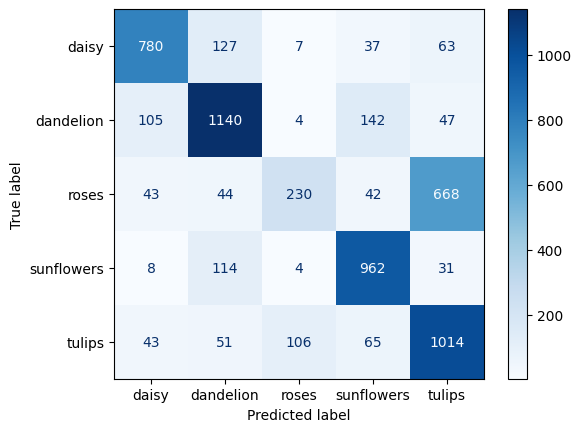

Confusion matrix image saved as outputs/v5/confusion_matrix.png
Evaluation saved as outputs/v5/model_evaluation.json


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 220, 220, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 220, 220, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 106, 106, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 106, 106, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 49, 49, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,627,857 (55.80 MB)

 Trainable params: 4,875,845 (18.60 MB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 9,751,692 (37.20 MB)

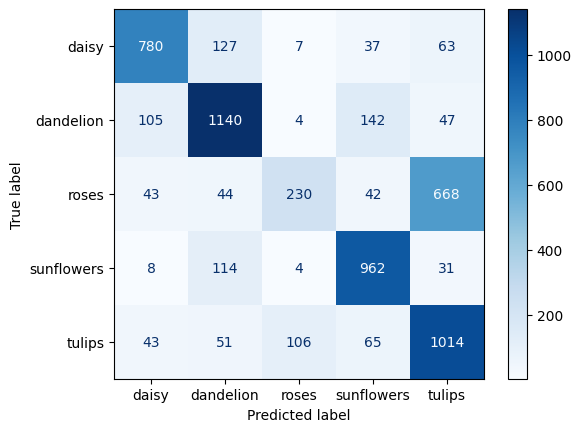

In [13]:
pipeline.evaluate(savepath=f"{file_path}/model_evaluation.json", cm_image_path=f"{file_path}/confusion_matrix.png")
pipeline.model_summary()

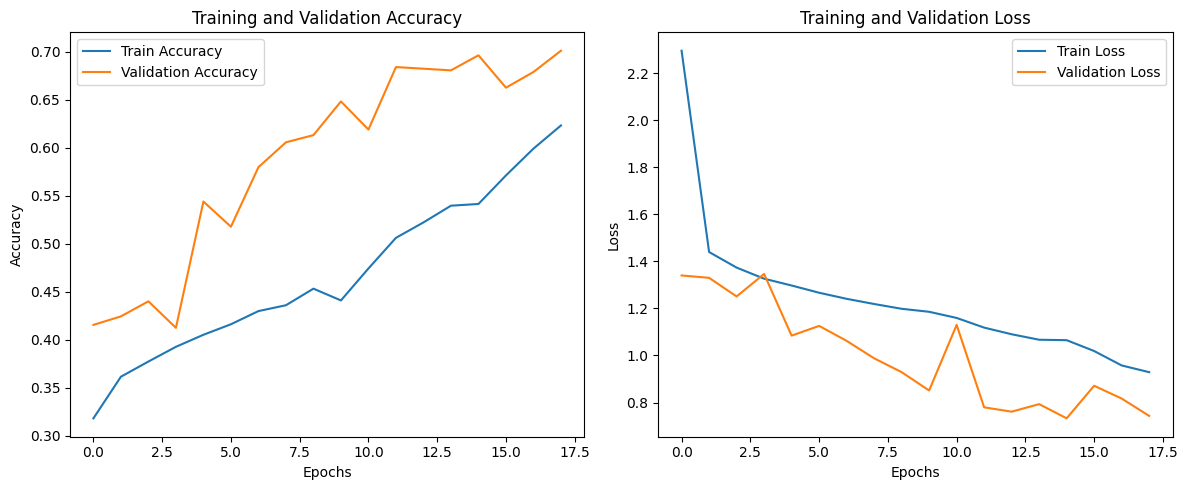

In [14]:
pipeline.plot_training_history(savepath=f"{file_path}/training_history.png")

In [15]:
json_file = f"{file_path}/model_evaluation.json"

with open(json_file, 'r') as f:
    evaluation_data = json.load(f)
    
print(f"Weighted F1 Score: {evaluation_data['f1_score_weighted']:.4}\n")


# Transforms the JSON-file to a more readable DataFrame
classification_report_df = pd.DataFrame(evaluation_data['classification_report']).transpose()
classification_report_df = classification_report_df.round(4)

classification_report_df = pd.concat([
    classification_report_df.iloc[:-3],  
    pd.DataFrame([[''] * len(classification_report_df.columns)], columns=classification_report_df.columns),  
    classification_report_df.iloc[-3:]  
]).reset_index()

classification_report_df.index.name = None

pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.width', 100)

print("Classification Report:\n", classification_report_df.to_string(index=False))

# Creates a DataFrame for the confussion matrix
labels = list(evaluation_data['classification_report'].keys())[:-3] # Excludes the last 3 labels
confussion_matrix_df = pd.DataFrame(
    evaluation_data['confusion_matrix'],
    index = labels,
    columns = labels
)

print("\nConfussion Matrix:\n", confussion_matrix_df)



Weighted F1 Score: 0.6819

Classification Report:
    index     precision  recall f1-score support
       daisy   0.7967   0.7692  0.7827   1014.0
   dandelion   0.7724   0.7928  0.7824   1438.0
       roses   0.6553    0.224  0.3338   1027.0
  sunflowers   0.7708   0.8597  0.8128   1119.0
      tulips   0.5562   0.7928  0.6538   1279.0
           0                                   
    accuracy   0.7021   0.7021  0.7021   0.7021
   macro avg   0.7103   0.6877  0.6731   5877.0
weighted avg   0.7088   0.7021  0.6819   5877.0

Confussion Matrix:
             daisy  dandelion  roses  sunflowers  tulips
daisy        780      127        7        37        63 
dandelion    105     1140        4       142        47 
roses         43       44      230        42       668 
sunflowers     8      114        4       962        31 
tulips        43       51      106        65      1014 


In [ ]:
def predict_random_image(model, label_map, img_path, target_size=(224, 224)):
    
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  

    # Makes a prediction of a random image
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = label_map[predicted_class]
    confidence = predictions[0][predicted_class] * 100


    plt.imshow(img)
    plt.title(f"Prediction: {predicted_label} ({confidence:.2f}% confidence)")
    plt.axis('off')
    plt.show()


test_dir = "inputs/dataset/raw/flower_photos/test"  
random_class = random.choice(os.listdir(test_dir))  # Choose a random image
random_img_path = os.path.join(test_dir, random_class, random.choice(os.listdir(os.path.join(test_dir, random_class))))

# Prediction of an image
predict_random_image(pipeline.model, pipeline.label_map, random_img_path)

<hr>

## Results


| Version | Balanced / Unbalanced | Layers           | Kernels       | Total params   | Runtime | Accuracy | F1-Score | Comments                                                        |
| ------- | --------------------- | ---------------- | -------------  | -------------- | ------- | -------- | -------- | --------------------------------------------------------------- |
| 1       | Unbalanced            | 32 - 64 - 128    | 3x3, 3x3, 3x3 | 33,508,817     | 209 min | 0.8329   | 0.8336   | Good result, though very large model file. Going to half the layers and see if the result will be the same and lesser size of the .h5-file |
| 2       | Unbalanced            | 16 - 32 - 64     | 3x3, 3x3, 3x3 | 8,378,609      | 124 min | 0.8258   | 0.8244   | Good result, almost the same result when decreasing the layers to the half of the first version. The model now are around 33Mb instead of over 130Mb with the first model |
| 3       | Unbalanced            | 16 - 32 - 64     | 5x5, 5x5, 5x5 | 7,274,993      | 156 min | 0.8167   | 0.8183   | Good result, almost identical even when increasing the kernel size. Still the largest confusion is between tulips and roses |
| 4       | Unbalanced            | 16 - 32 - 64     | 5x5, 5x5, 5x5 | 223,729      | 55 min | 0.7087   | 0.6998   | Tried GlobalAveragePooling2D instead of Flatten on this layer and it didn´t go so well. Changing back to Flatten for the next version and increasing the layers. |
| 5       | Unbalanced            | 32 - 64 - 64     | 5x5, 5x5, 5x5 | 14,627,857      | 347 min | 0.7021   | 0.6819   | Adjust the augmentation with this model and the performance decreased instead. Will try next time with a balanced version 2. See if the performance of that can increase |